# Схемы валидации

## Imports

In [ ]:
!pip install rectools

In [1]:
import pandas as pd
import numpy as np

import requests
from tqdm.auto import tqdm

from rectools import Columns

## Get KION dataset

In [8]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [9]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [4]:
#!unzip kion.zip

In [10]:
import zipfile as zf

files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

### Read data

In [11]:
interactions = pd.read_csv('data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [12]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [15]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [17]:
interactions.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


## Validation

### Random 

In [18]:
%%time
test_size = 0.2
interactions['is_train'] = np.random.rand(interactions.shape[0]) > test_size

CPU times: user 50 ms, sys: 15.6 ms, total: 65.6 ms
Wall time: 64.5 ms


In [19]:
interactions['is_train'].value_counts()

True     4380005
False    1096246
Name: is_train, dtype: int64

In [20]:
train = interactions[interactions['is_train'] == 1]
test = interactions[interactions['is_train'] == 0]
print(f'Train: {train.shape[0]}, Test: {test.shape[0]}')

Train: 4380005, Test: 1096246


In [21]:
del interactions['is_train']

Генерация через маски

In [22]:
%%time
test_size = 0.2
train_mask = np.random.rand(interactions.shape[0]) > test_size
test_mask = ~train_mask

CPU times: user 54.3 ms, sys: 12.1 ms, total: 66.4 ms
Wall time: 64 ms


In [24]:
train = interactions[train_mask]
test = interactions[test_mask]
print(f'Train: {train.shape[0]}, Test: {test.shape[0]}')

Train: 4380790, Test: 1095461


Это легко обернуть в функцию для повторного вызова

In [25]:
def repeated_train_test_split(n_folds, df_size, test_size=0.2):
    for _ in range(n_folds):
        train_mask = np.random.rand(interactions.shape[0]) > test_size
        test_mask = ~train_mask
        yield train_mask, test_mask

In [26]:
iterator = repeated_train_test_split(3, interactions.shape[0], test_size=0.5)

for i, (train_mask, test_mask) in enumerate(iterator):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 2738953, Test: 2737298
Fold#1 | Train: 2739493, Test: 2736758
Fold#2 | Train: 2737940, Test: 2738311


Как лучше зафиксировать `random_seed`

In [27]:
def repeated_train_test_split_1(n_folds, df_size, test_size=0.2, random_seed=23):
    np.random.seed(random_seed)
    for _ in range(n_folds):
        train_mask = np.random.rand(interactions.shape[0]) > test_size
        test_mask = ~train_mask
        yield train_mask, test_mask
        
def repeated_train_test_split_2(n_folds, df_size, test_size=0.2, random_seed=23):
    for _ in range(n_folds):
        np.random.seed(random_seed)
        train_mask = np.random.rand(interactions.shape[0]) > test_size
        test_mask = ~train_mask
        yield train_mask, test_mask

In [28]:
iterator_1 = repeated_train_test_split_1(3, interactions.shape[0], test_size=0.5)
folds_1 = np.array([sum(train_mask) for train_mask, _ in iterator_1])

iterator_2 = repeated_train_test_split_2(3, interactions.shape[0], test_size=0.5)
folds_2 = np.array([sum(train_mask) for train_mask, _ in iterator_2])
print(folds_1, folds_2)

[2738244 2738742 2738953] [2738244 2738244 2738244]


In [29]:
iterator_1 = repeated_train_test_split_1(3, interactions.shape[0], test_size=0.5)
folds_1 = np.array([sum(train_mask) for train_mask, _ in iterator_1])

iterator_2 = repeated_train_test_split_2(3, interactions.shape[0], test_size=0.5)
folds_2 = np.array([sum(train_mask) for train_mask, _ in iterator_2])
print(folds_1, folds_2)

[2738244 2738742 2738953] [2738244 2738244 2738244]


`sklearn-like` класс для разбиения на фолды

In [30]:
class RepeatedRandomSplit():
    def __init__(self, n_folds, test_size=0.2, random_seed=23):
        self.n_folds = n_folds
        self.test_size = test_size
        self.random_seed = random_seed
    
    def split(self, df):
        np.random.seed(self.random_seed)
        for _ in range(self.n_folds):
            train_mask = np.random.rand(df.shape[0]) > self.test_size
            test_mask = ~train_mask
            yield train_mask, test_mask

In [31]:
cv = RepeatedRandomSplit(n_folds=3, test_size=0.5, random_seed=23)
for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 2738244, Test: 2738007
Fold#1 | Train: 2738742, Test: 2737509
Fold#2 | Train: 2738953, Test: 2737298


### Time-based

Вначале поверхностно изучим данные

In [32]:
interactions[Columns.Datetime].min(), interactions[Columns.Datetime].max()

(Timestamp('2021-03-13 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [33]:
daily_inters = interactions.groupby(Columns.Datetime)[Columns.User].agg('count')
daily_inters.name = 'interactions'
headtail(daily_inters)                    

datetime
2021-03-13    16104
2021-03-14    15606
2021-03-15    12363
2021-03-16    12643
2021-03-17    12753
2021-08-18    56789
2021-08-19    58640
2021-08-20    60145
2021-08-21    68834
2021-08-22    71171
Name: interactions, dtype: int64

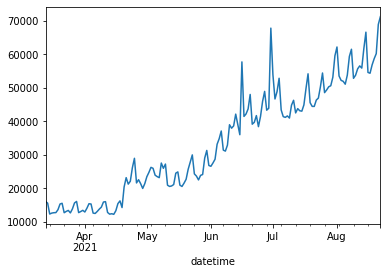

In [34]:
ax = daily_inters.plot()

In [35]:
import plotly.express as px

In [37]:
fig = px.bar(daily_inters)
fig.show()

In [38]:
pd.to_datetime('1-08-2021', format='%d-%m-%Y').weekday()

6

Видно недельный тренд, давайте для test выделим последнюю неделю

In [40]:
last_date = interactions[Columns.Datetime].max()
last_date.weekday()

6

In [41]:
threshold = last_date - pd.Timedelta(weeks=1)
train_mask = interactions[Columns.Datetime] <= threshold
test_mask = interactions[Columns.Datetime] > threshold

In [42]:
train = interactions[train_mask]
test = interactions[test_mask]
print(f'Train: {train.shape[0]}, Test: {test.shape[0]}')

Train: 5051815, Test: 424436


Разовьем идею для нескольких фолдов. Надо учитывать, что для выделения последующих тестовых фолдов нам надо ограничивать их предыдущим значением. Тогда схематично фолыд будут выглядеть так:
- `[..., w4, w3, w2] | [w1]`
- `[..., w4, w3] | [w2]`
- `[..., w4] | [w3]`
- `...`
- `[..., w_(N+1)] | [wN]`

Если для веделения `w1` нам достаточно только одной даты `t1`, то для `w2` надо знать и `t1`, и `t2`. В общем случае алгоритм такой:
- Train: `df[date] <= tN`
- Test: `(df[date] > tN) & (df[date] <= t(N-1))`

In [43]:
class TimeSplit():
    def __init__(self, n_folds, delta, date_column=Columns.Datetime):
        self.n_folds = n_folds
        self.delta = delta
        self.date_column = date_column
    
    def split(self, df):
        last_date = df[self.date_column].max()
        
        prev_threshold = last_date
        threshold = last_date - self.delta
        
        for _ in range(self.n_folds):
            train_mask = interactions[self.date_column] <= threshold
            test_mask = (interactions[self.date_column] > threshold) & (interactions[self.date_column] <= prev_threshold)
            prev_threshold = threshold
            threshold -= self.delta
            yield train_mask, test_mask

In [44]:
delta = pd.Timedelta(weeks=1)
cv = TimeSplit(3, delta)
for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 5051815, Test: 424436
Fold#1 | Train: 4649162, Test: 402653
Fold#2 | Train: 4266013, Test: 383149


Видно, что в случае разбиения по времени, нам нужно всего лишь задать точки (даты), по которым мы будем делить датасет. Причем идем мы по ним попарно. Для создания такого массива подходит [pandas.date_range](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html)

In [34]:
pd.date_range(start=last_date, periods=8)

DatetimeIndex(['2021-08-22', '2021-08-23', '2021-08-24', '2021-08-25',
               '2021-08-26', '2021-08-27', '2021-08-28', '2021-08-29'],
              dtype='datetime64[ns]', freq='D')

In [35]:
n_folds = 3
unit = "W"
n_units = 1

start_date = last_date - pd.Timedelta(n_folds * n_units, unit=unit)
periods = n_folds + 1
freq = f"{n_units}{unit}"
print(f"""
    start_date: {start_date}
    last_date: {last_date}
    periods: {periods}
    freq: {freq}
""")

date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
date_range



    start_date: 2021-08-01 00:00:00

    last_date: 2021-08-22 00:00:00

    periods: 4

    freq: 1W




DatetimeIndex(['2021-08-01', '2021-08-08', '2021-08-15', '2021-08-22'], dtype='datetime64[ns]', freq='W-SUN')

Для попарной итераци по массиву пригодится магия из [itertools](https://docs.python.org/3/library/itertools.html), а конкретнее - [pairwise](https://docs.python.org/3/library/itertools.html#itertools.pairwise). Как отдельная функция она появилась только в python 3.10, поэтому придется воспроизвести ее самим

In [36]:
from itertools import tee

def pairwise(iterable):
    # pairwise('ABCDEFG') --> AB BC CD DE EF FG
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [37]:
for i, (start, end) in enumerate(pairwise(date_range)):
    print(f'Fold#{i} | Train <= {start.date()} | {start.date()} < Test <= {end.date()}')

Fold#0 | Train <= 2021-08-01 | 2021-08-01 < Test <= 2021-08-08

Fold#1 | Train <= 2021-08-08 | 2021-08-08 < Test <= 2021-08-15

Fold#2 | Train <= 2021-08-15 | 2021-08-15 < Test <= 2021-08-22


In [38]:
class TimeSplit():
    def __init__(self, date_range, date_column=Columns.Datetime):
        self.date_range = date_range
        self.date_column = date_column
    
    def split(self, df):
        for i, (start, end) in enumerate(pairwise(self.date_range)):
            train_mask = interactions[self.date_column] <= start
            test_mask = (interactions[self.date_column] > start) & (interactions[self.date_column] <= end)
            yield train_mask, test_mask

In [39]:
cv = TimeSplit(date_range)

for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 4266013, Test: 383149

Fold#1 | Train: 4649162, Test: 402653

Fold#2 | Train: 5051815, Test: 424436


### Hot/Cold scenario

Определим, как модифицировать класс TimeSplit, чтобы можно было контроилровать попадание/исключение холодных пользователей и объектов из теста. Рассмотрим пример на основе уже выделенных `train` и `test`

In [40]:
print(f'Train: {train.shape[0]}, Test: {test.shape[0]}')

Train: 5051815, Test: 424436


По определению холодным пользователем или объектом считаются те, которых не было в `train`, но есть в `test`. Реализуем это через пересечение массивов

In [41]:
train_users = train[Columns.User].unique()
test_users = test[Columns.User].unique()
cold_users = np.setdiff1d(test_users, train_users)
print(len(cold_users))

56108


In [42]:
print(f'Test before: {test.shape[0]}')
new_test_mask = test_mask & (~test[Columns.User].isin(cold_users))
new_test = interactions[new_test_mask]
print(f'Test after: {new_test.shape[0]}')

Test before: 424436

Test after: 306752


In [43]:
test.shape[0] - new_test.shape[0]

117684

Добавим эту логику в наш класс TimeSplit

In [44]:
class TimeSplit():
    def __init__(self, date_range, filter_cold_users=True, date_column=Columns.Datetime):
        self.date_range = date_range
        self.filter_cold_users = filter_cold_users
        self.date_column = date_column
    
    def split(self, df):
        for i, (start, end) in enumerate(pairwise(self.date_range)):
            train_mask = interactions[self.date_column] <= start
            test_mask = (interactions[self.date_column] > start) & (interactions[self.date_column] <= end)
            
            if self.filter_cold_users:
                train_users = df.loc[train_mask, Columns.User].unique()
                test_users = df.loc[test_mask, Columns.User].unique()
                cold_users = np.setdiff1d(test_users, train_users)
                test_mask &= ~df.loc[test_mask, Columns.User].isin(cold_users)

            yield train_mask, test_mask

In [45]:
cv = TimeSplit(date_range)

for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 4266013, Test: 271321

Fold#1 | Train: 4649162, Test: 288328

Fold#2 | Train: 5051815, Test: 306752


In [46]:
cv = TimeSplit(date_range, filter_cold_users=False)

for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 4266013, Test: 383149

Fold#1 | Train: 4649162, Test: 402653

Fold#2 | Train: 5051815, Test: 424436


### UsersKFold

Один из видов случайного разбиения является `KFold` по пользователям или объектам. Идея в том, чтобы разбить данные на `train` и `test` так, чтобы пользователи между ними не пересекались. Можно сказать, что это сочетание `Random + Warm start scenario`.

Если все данные обозначить как `[u1, u2, ..., uN]`, то для `KFold(k=3)`:
- Test: `[u1, ..,, u(N//3)]` Train: `[u(N//3 + 1), ..., uN]`
- Test: `[u(N//3 + 1), ..,, u(2*N//3)]` Train: `[u1, ..., u(N//3 + 1)] & [u(2*N//3 + 1), ..., uN]`
- Test: `[u(2*N//3 + 1), ..,, uN]` Train: `[u1, ..., u(2*N//3)]`

In [47]:
class UsersKFold():
    def __init__(self, n_folds, user_column=Columns.User, random_seed=23):
        self.n_folds = n_folds
        self.user_column = user_column
        self.random_seed = random_seed
    
    def split(self, df):
        users = df[self.user_column].unique()
        users_count = len(users)
        
        np.random.seed(self.random_seed)
        np.random.shuffle(users)
        
        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=int)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users)
            train_mask = ~test_mask
            
            yield train_mask, test_mask

In [48]:
cv = UsersKFold(3)

for i, (train_mask, test_mask) in enumerate(cv.split(interactions)):
    train = interactions[train_mask]
    test = interactions[test_mask]
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 3639741, Test: 1836510

Fold#1 | Train: 3639742, Test: 1836509

Fold#2 | Train: 3639742, Test: 1836509


## Homework

Исходные данные - Yandex Cup 2022 RecSys:
- Описание соревнования - https://contest.yandex.ru/yacup/contest/41618/problems/
- Данные - https://disk.yandex.ru/d/SI1aAooPn9i8TA
- Описание данных - в архиве likes_data.zip три файла:
  - train - обучающий набор данных. Каждая строка - последовательность id треков, которые лайкнул один пользователь. Гарантируется, что лайки даны в той последовательности, в которой их ставил пользователь.
  - test - набор тестовых данных. Имеет точно такой же формат, но в каждой строке не хватает последнего лайка, который надо предсказать.
  - track_artists.csv - информация о исполнителях треков. Гарантируется, что у каждого трека есть ровно один исполнитель. Для треков, у которых фактически несколько исполнителей, мы оставили того, который считается основным исполнителем трека.
- Описание сабмита - в качестве решения необходимо отправить файл, в котором для каждого пользователя из test в отдельной строке будет не более 100 треков, разделенных пробелом. Гарантируется, что у каждого пользователя будет только 1 лайк в тесте
- Метрика - MRR@100

Промежуточная задача - преобразовать данные в pandas.DataFrame вида {user, item, order}, где order - порядковый номер с конца (0 - самый "свежий" лайк, чем больше order, тем позже был поставлен лайк)

**Итоговая задача** - построить схему валидации для данного соревнования с учетом особенностей сорвенования
- Между `train` и `test` не должно быть общих пользователей
- Количество фолдов задается через параметр класса `n_folds`
- В `test` должно быть не более `p` последних треков (параметр класса `p`)

In [3]:
yandex_data = pd.read_csv('../input/recsys-yandex-cup-2022/dataframe.csv/dataframe.csv') # Подгружаем данные

In [4]:
yandex_data = yandex_data.drop(['rank', 'reversed_rank', 'is_train'], axis=1)
yandex_data = yandex_data.rename({'user_id': 'user', 'track_id': 'item'}, axis=1)
yandex_data['order'] = yandex_data.groupby('user')['item'].cumcount() # Предобработка и добавление порядка

In [9]:
class UsersKFoldPOut():
    def __init__(
        self,
        n_folds: int,
        p: int,
        rank_col: str = 'order',
        user_column: str = 'user',
        random_seed: int = 23
    ):
        self.n_folds = n_folds
        self.p = p
        self.rank_col = rank_col
        self.user_column = user_column
        self.random_seed = random_seed
        
    
    def split(self, df):
        users = df[self.user_column].unique()
        users_count = len(users)
        
        np.random.seed(self.random_seed)
        np.random.shuffle(users)
        
        fold_sizes = np.full(self.n_folds, users_count // self.n_folds, dtype=int)
        fold_sizes[: users_count % self.n_folds] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_fold_users = users[start:stop]
            test_mask = df[self.user_column].isin(test_fold_users)
            train_mask = ~test_mask
            # Берем только те сэмплы, для которых порядок меньше p
            test_mask = test_mask & (df[self.rank_col] < self.p)
            
            yield train_mask, test_mask

In [17]:

par = 5
cv = UsersKFoldPOut(n_folds=3, p=par)

for i, (train_mask, test_mask) in enumerate(cv.split(yandex_data)):
    train = yandex_data[train_mask]
    test = yandex_data[test_mask]
    # Проверка, что нет пересечения train и test
    assert set() == set(train.user).intersection(test.user)
    # Проверка, что нет рангов больше p
    assert test[test.order > par].shape[0] == 0
    
    print(f'Fold#{i} | Train: {train.shape[0]}, Test: {test.shape[0]}')

Fold#0 | Train: 78277912, Test: 1933475
Fold#1 | Train: 78277912, Test: 1933475
Fold#2 | Train: 78277978, Test: 1933470
